In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)

100%|██████████| 10.7G/10.7G [02:17<00:00, 83.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1


In [3]:
import pandas as pd

# Cargar el archivo CSV de entrenamiento y validación
df_train = pd.read_csv('/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train.csv')
df_valid = pd.read_csv('/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/valid.csv')

# Filtrar pulmones sanos (No Finding == 1.0) y enfermos (No Finding == NaN) en el conjunto de entrenamiento
sanos_train = df_train[df_train["No Finding"] == 1.0]
enfermos_train = df_train[df_train["No Finding"].isna()]

# Seleccionar aleatoriamente 1500 imágenes sanas y 1500 enfermas
sanos_valid = sanos_train.sample(n=2500, random_state=42)
enfermos_valid = enfermos_train.sample(n=2500, random_state=42)

# Eliminar las imágenes seleccionadas para validación del conjunto de entrenamiento
df_train = df_train[~df_train["Path"].isin(sanos_valid["Path"])]  # Eliminar sanos
df_train = df_train[~df_train["Path"].isin(enfermos_valid["Path"])]  # Eliminar enfermos

# Unir las nuevas imágenes sanas y enfermas al conjunto de validación
valid_combined = pd.concat([df_valid, sanos_valid, enfermos_valid])

# Guardar el nuevo conjunto de validación en un CSV
valid_combined.to_csv("/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/valid_combined.csv", index=False)

# Guardar el nuevo conjunto de entrenamiento en un CSV (sin las imágenes seleccionadas para validación)
df_train.to_csv("/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train_updated.csv", index=False)

# Verificar que el conjunto de validación ahora tenga 3000 imágenes adicionales
print(f"Total imágenes en el nuevo conjunto de validación: {valid_combined.shape[0]}")
print(f"Total imágenes en el conjunto de entrenamiento actualizado: {df_train.shape[0]}")


Total imágenes en el nuevo conjunto de validación: 5234
Total imágenes en el conjunto de entrenamiento actualizado: 218414


In [15]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Ruta base del dataset
dataset_path = "/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/"

# Cargar CSV y filtrar pulmones sanos
csv_path = os.path.join(dataset_path, "train_updated.csv")
df = pd.read_csv(csv_path)

# Filtrar solo las imágenes con "No Finding" == 1.0
df_sanos = df[df["No Finding"] == 1.0].copy()

# Quitar "CheXpert-v1.0-small/" del Path
df_sanos["Path"] = df_sanos["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

# Construir rutas absolutas
image_paths = [os.path.join(dataset_path, path) for path in df_sanos["Path"].tolist()]

# Limitar a 20,000 imágenes si es necesario
image_paths = image_paths[:5000]

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CheXpertDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convertir a escala de grises

        if self.transform:
            image = self.transform(image)

        return image, 0  # Etiqueta dummy (para autoencoder)

# Crear datasets y dataloaders
dataset = CheXpertDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Filtrar imágenes sanas para validación
valid_csv_path = os.path.join(dataset_path, "valid_combined.csv")
df_valid = pd.read_csv(valid_csv_path)
df_valid_sanos = df_valid[df_valid["No Finding"] == 1.0].copy()

# Quitar "CheXpert-v1.0-small/" del Path
df_valid_sanos["Path"] = df_valid_sanos["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

# Construir rutas absolutas
valid_image_paths = [os.path.join(dataset_path, path) for path in df_valid_sanos["Path"].tolist()]

# Quitar "CheXpert-v1.0-small/" del Path
df_valid["Path"] = df_valid["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

# Construir rutas absolutas
valid_image_paths_all = [os.path.join(dataset_path, path) for path in df_valid["Path"].tolist()]

valid_dataset_all = CheXpertDataset(valid_image_paths_all, transform=transform)
valid_dataloader_all = DataLoader(valid_dataset_all, batch_size=32, shuffle=False)

valid_dataset = CheXpertDataset(valid_image_paths, transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [5]:
import torch.nn as nn
import torch.optim as optim


#Me creo una UNet pero sin skipped
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32 -> 16
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh() #probamos con funcion tangente hiperbolica
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


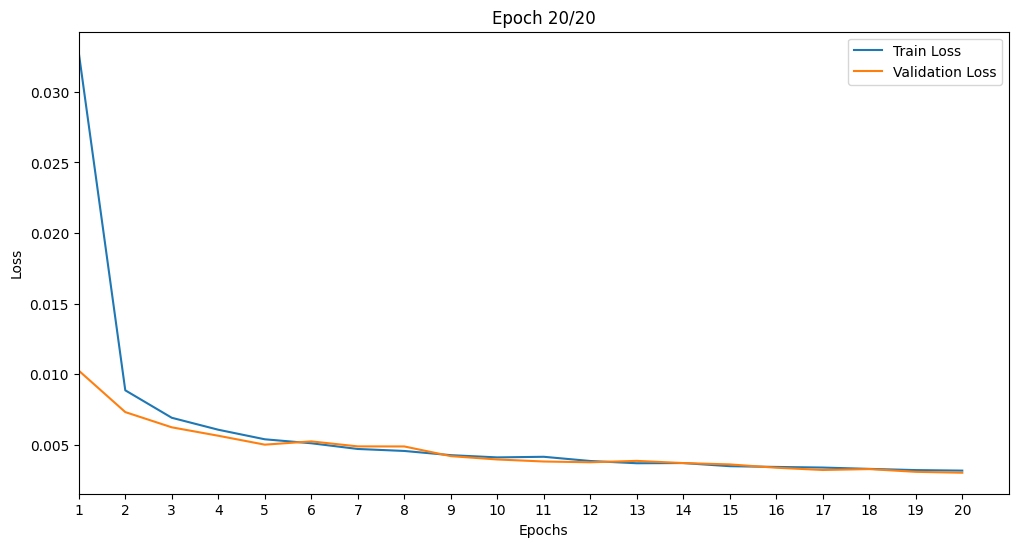

Epoch: 20 | Train Loss: 0.0032 | Val Loss: 0.0030: 100%|██████████| 20/20 [07:16<00:00, 21.82s/it]


In [6]:
#BORRAR

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

# Configuración del dispositivo y otros parámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Inicializar el modelo y el optimizador
model = UNetAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()  # Pérdida de error cuadrado medio

# Arreglos para las pérdidas
t_loss = np.zeros(epochs)
v_loss = np.zeros(epochs)

# Barra de progreso para el entrenamiento
pbar = tqdm(range(1, epochs + 1))

# Bucle de entrenamiento y validación
for epoch in pbar:
    train_loss = 0
    val_loss = 0

    # Etapa de entrenamiento
    model.train()
    for batch_num, (input_img, _) in enumerate(dataloader, 1):
        input_img = input_img.to(device)

        optimizer.zero_grad()
        output = model(input_img)
        loss = criterion(output, input_img)  # Pérdida de reconstrucción
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Etapa de validación
    model.eval()
    with torch.no_grad():
        for input_img, _ in valid_dataloader:
            input_img = input_img.to(device)

            output = model(input_img)
            loss = criterion(output, input_img)  # Pérdida de reconstrucción
            val_loss += loss.item()

    # Promediar las pérdidas por época
    train_loss /= len(dataloader)
    val_loss /= len(valid_dataloader)

    t_loss[epoch - 1] = train_loss
    v_loss[epoch - 1] = val_loss

    # Visualización dinámica de las pérdidas
    plt.figure(figsize=(12, 6))
    plt.plot(t_loss[:epoch], label="Train Loss")
    plt.plot(v_loss[:epoch], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Epoch {epoch}/{epochs}")
    plt.legend()
    plt.xlim(0, epochs)
    plt.xticks(range(0, epochs), range(1, epochs + 1))  # Corregido aquí

    # Limpiar salida y mostrar gráfico actualizado
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()


    # Actualizar la barra de progreso
    pbar.set_description(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


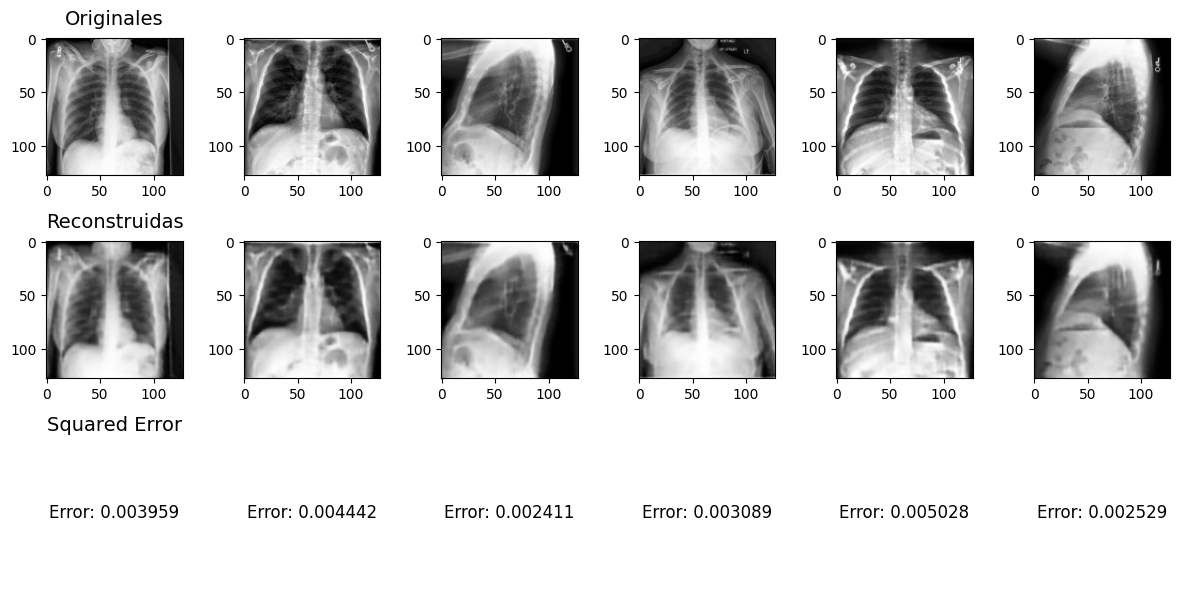

In [17]:
# Validación imagen original vs reconstruccion solo con imagenes de pulmones sanos

import numpy as np
import matplotlib.pyplot as plt

# Evaluación del modelo
model.eval()

# Obtener un batch de imágenes
test_images, _ = next(iter(valid_dataloader))
test_images = test_images.to(device)

# Generar reconstrucciones
reconstructed = model(test_images).cpu().detach()

# Calcular el squared error imagen por imagen
squared_errors = ((test_images.cpu().detach().numpy() - reconstructed.numpy()) ** 2).mean(axis=(1, 2, 3))

# Mostrar algunas imágenes y sus errores
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i in range(6):
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[1, i].imshow(reconstructed[i].squeeze(), cmap="gray")
    axes[2, i].text(0.5, 0.5, f"Error: {squared_errors[i]:.6f}", ha="center", va="center", fontsize=12)
    axes[2, i].axis("off")

# Ajustar títulos sin superposición
axes[0, 0].set_title("Originales", fontsize=14, pad=10)
axes[1, 0].set_title("Reconstruidas", fontsize=14, pad=10)
axes[2, 0].set_title("Squared Error", fontsize=14, pad=10)

plt.tight_layout()  # Evita superposiciones
plt.show()


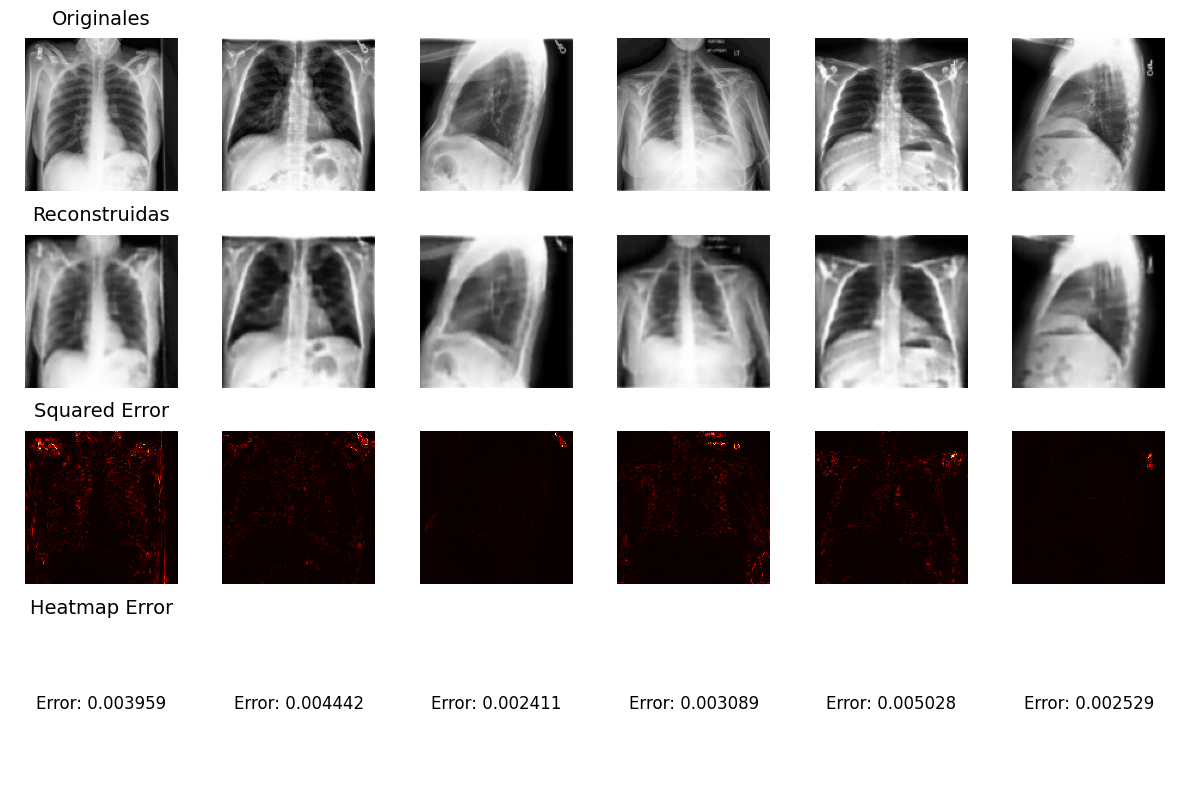

In [19]:
#Imagen original vs reconstruida vs error por pixel (heatmap)

import numpy as np
import matplotlib.pyplot as plt

# Evaluación del modelo
model.eval()

# Obtener un batch de imágenes
test_images, _ = next(iter(valid_dataloader))
test_images = test_images.to(device)

# Generar reconstrucciones
reconstructed = model(test_images).cpu().detach()

# Calcular el squared error imagen por imagen
squared_errors = ((test_images.cpu().detach().numpy() - reconstructed.numpy()) ** 2).mean(axis=(1, 2, 3))

# Calcular error por píxel para generar heatmap
pixel_errors = (test_images.cpu().detach().numpy() - reconstructed.numpy()) ** 2

# Mostrar imágenes, reconstrucciones, errores y heatmaps
fig, axes = plt.subplots(4, 6, figsize=(12, 8))  # 4 filas: original, reconstrucción, error numérico, heatmap

for i in range(6):
    # Imagen original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")

    # Imagen reconstruida
    axes[1, i].imshow(reconstructed[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")

    # Heatmap del error pixel a pixel
    axes[2, i].imshow(pixel_errors[i].squeeze(), cmap="hot", interpolation="nearest")
    axes[2, i].axis("off")

    # Error cuadrático medio numérico
    axes[3, i].text(0.5, 0.5, f"Error: {squared_errors[i]:.6f}",
                    ha="center", va="center", fontsize=12)
    axes[3, i].axis("off")


# Ajustar títulos sin superposición
axes[0, 0].set_title("Originales", fontsize=14, pad=10)
axes[1, 0].set_title("Reconstruidas", fontsize=14, pad=10)
axes[2, 0].set_title("Squared Error", fontsize=14, pad=10)
axes[3, 0].set_title("Heatmap Error", fontsize=14, pad=10)

plt.tight_layout()  # Evita superposiciones
plt.show()


Sanas seleccionadas: 3, Enfermas seleccionadas: 3


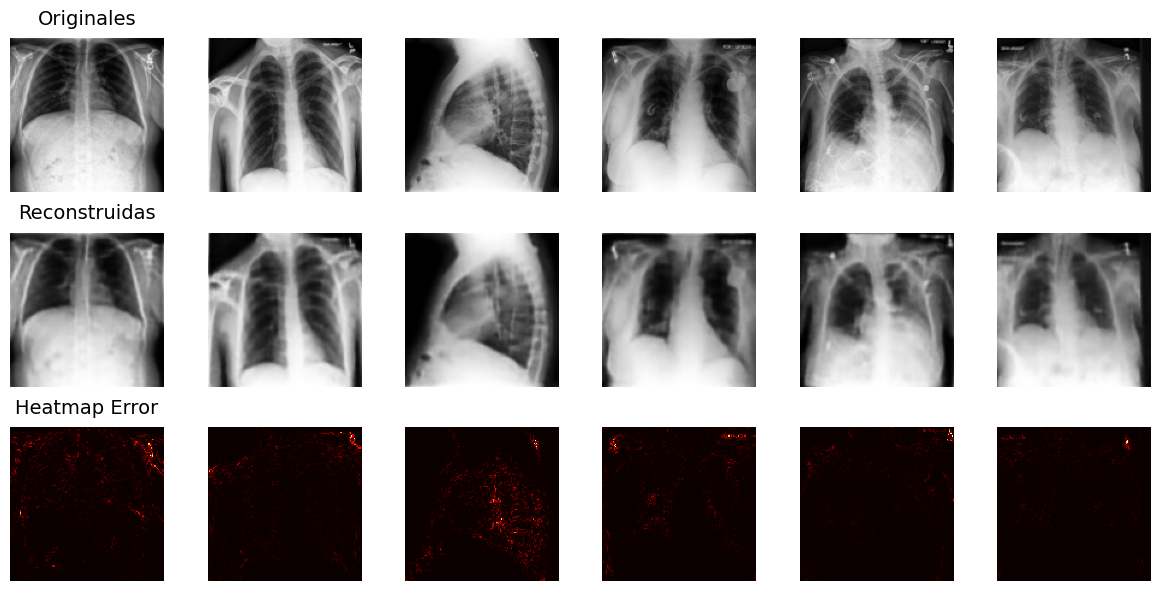

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
import torchvision.transforms as transforms

# Ruta del dataset
dataset_path = "/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/"

# Cargar CSV de validación
valid_csv_path = os.path.join(dataset_path, "valid.csv")
valid_df = pd.read_csv(valid_csv_path)

# Corregir las rutas en la columna "Path"
valid_df["Path"] = valid_df["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

# Filtrar pulmones sanos y enfermos
healthy_images = valid_df[valid_df["No Finding"] == 1.0]["Path"].tolist()
sick_images = valid_df[valid_df["No Finding"] != 1.0]["Path"].tolist()

# Asegurar que no seleccionamos más imágenes de las disponibles
num_samples = 3
selected_healthy = random.sample(healthy_images, min(num_samples, len(healthy_images)))
selected_sick = random.sample(sick_images, min(num_samples, len(sick_images)))


# Construir rutas absolutas
selected_paths = [os.path.join(dataset_path, path) for path in selected_healthy + selected_sick]

# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

# Cargar imágenes y procesarlas
images = []
for path in selected_paths:
    img = Image.open(path).convert("L")  # Convertir a escala de grises
    img = transform(img)
    images.append(img)

print(f"Sanas seleccionadas: {len(selected_healthy)}, Enfermas seleccionadas: {len(selected_sick)}")


# Convertir a tensor y enviar a GPU si está disponible
images = torch.stack(images).to(device)

# Generar reconstrucciones
model.eval()
with torch.no_grad():
    reconstructed = model(images).cpu()

# Calcular el squared error imagen por imagen
squared_errors = ((images.cpu().numpy() - reconstructed.numpy()) ** 2).mean(axis=(1, 2, 3))

# Calcular error por píxel para heatmap
pixel_errors = (images.cpu().numpy() - reconstructed.numpy()) ** 2

# Crear la figura con 3 filas (original, reconstrucción, heatmap) y 6 columnas (3 sanos + 3 enfermos)
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i, img in enumerate(images):
    # Imagen original
    axes[0, i].imshow(img.cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")

    # Imagen reconstruida
    axes[1, i].imshow(reconstructed[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")

    # Heatmap del error pixel a pixel
    axes[2, i].imshow(pixel_errors[i].squeeze(), cmap="hot", interpolation="nearest")
    axes[2, i].axis("off")

# Etiquetas de las filas
axes[0, 0].set_title("Originales", fontsize=14, pad=10)
axes[1, 0].set_title("Reconstruidas", fontsize=14, pad=10)
axes[2, 0].set_title("Heatmap Error", fontsize=14, pad=10)

plt.tight_layout()  # Evita superposiciones
plt.show()
